This notebook generates networks

In [81]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [82]:
# Parameter input
PERIODS = 5000
TYPE_DISTRIBUTION = [[1/2, 1/2], [1/2, 1/2]]   # e.g. [[t1_s1, t2_s1], [t1_s2, t2_s2]]
POPULATION = [24, 24]
BELIEF_OPTION = 5
DELTA = 0.7
COST_LOW = 0.1
COST_HIGH = 1.0
# INFORMATION = np.identity(np.sum(POPULATION)) # identity for incomplete info, np.ones((np.sum(POPULATION),np.sum(POPULATION))) for complete info
INFORMATION = np.ones((np.sum(POPULATION),np.sum(POPULATION))) 
MAX_CYCLES = 3

# Global constants
# COLOURS = ['firebrick', 'tomato', 'peru','darkgreen', 'mediumseagreen', 'teal']
COLOURS = ['firebrick', 'tomato','darkgreen', 'mediumseagreen']
RANDOM_SEED = 42
REPEATS = 10
BUDGET = 10

# Activate graph generator
GENERATE = True
PATH = './saved-48-5-0.7'
LOGFILE = f"{PATH}/log.txt"

# Activate testing
TEST = False


==============================================================================================================================

In [83]:
# option 0 - rational expectations
# option 1 - uniform U[0,1]
# option 2 - uniform U[0,1] for same social group, else U[0,1] but capped
# option 3 - beta[5,2] 
# option 4 - beta[5,2] for same social group, else beta[5,2] but capped
# option 5 - beta[5,2] for same social group, else beta[5,2] but scaled to cap

def create_beliefs(option, typeID, groupID, type_distribution, custom=[]):
    beliefs = []
    
    # rational expectations
    if (option == 0):
        for group in type_distribution:
            beliefs.append(group[typeID])
    
    # uniform U[0,1]
    if (option == 1):
        for group in type_distribution:
            beliefs.append(random.uniform(0,1))
    
    # uniform U[0,1] for same social group, else U[0,cap]
    if (option == 2):
        cap = random.uniform(0,1)
        for i, group in enumerate(type_distribution):
            if (i == groupID):
                beliefs.append(cap)
            else:
                beliefs.append(min(random.uniform(0,1), cap))
                
    # beta[5,2] 
    if (option == 3):
        for group in type_distribution:
            beliefs.append(random.betavariate(5,2))
    
    # beta[5,2] for same social group, else beta[5,2] but capped
    if (option == 4):
        cap = random.betavariate(5,2)
        for i, group in enumerate(type_distribution):
            if (i == groupID):
                beliefs.append(cap)
            else:
                beliefs.append(min(random.betavariate(5,2), cap))
                
    # beta[5,2] for same social group, else beta[5,2] but scaled to [0, cap]
    if (option == 5):
        cap = random.betavariate(5,2)
        for i, group in enumerate(type_distribution):
            if (i == groupID):
                beliefs.append(cap)
            else:
                beliefs.append(random.betavariate(5,2) * cap)
                
    if (option == -1):
        return custom
    
    return beliefs

In [84]:
# Helper function - calculates utility and cost separately for a given pair
def calculate_utility_and_cost(G, source_node, target_node, new_node=None):
    u, c = 0, 0
    delta = G.graph['delta']
    cost_low = G.graph['cost_low']
    cost_high = G.graph['cost_high']
    
    if (nx.has_path(G, source_node, target_node)):
        path_length = nx.shortest_path_length(G, source_node, target_node)
        u += delta ** path_length
        if (path_length == 1):
            if (target_node != new_node or G.graph['information'][source_node-1,target_node-1] == 1):
                c += -cost_low if G.nodes[target_node]['type'] == G.nodes[source_node]['type'] else -cost_high
            else:
                pi = G.nodes[source_node]['beliefs'][G.nodes[target_node]['group']] # belief index given by target's group ID
                c += -cost_low * pi -cost_high * (1-pi)
    return u, c

In [85]:
# Calculate net utility of a given agent in a graph
def calculate_net_utility(G, source_node, new_node=None):
    u, c = 0, 0
    for i in range (0, G.number_of_nodes()):
        target_node = 1 + i
        u_i, c_i = calculate_utility_and_cost(G, source_node, target_node, new_node)
        u += u_i
        c += c_i
    return u + c

In [86]:
# Populates graph and returns an array with the number of agents in each category
def populate_graph(G, population, type_distribution, belief_option, custom_beliefs=None):
    
    if (len(type_distribution) < len(population)):
        raise ValueError("Insufficient type distributions specified")

    id = 1
    
    population_breakdown = []
    
    # for each group (overt type) there is a different distribution
    for grp, distribution in enumerate(type_distribution):
        
        # get the distribution over (covert) types for each (overt) group
        create = np.floor(np.multiply(population[grp], distribution)).astype(np.int64)

        # top up if there is a short-fall
        if (np.sum(create) < population[grp]):
            create[0] += 1
        
        population_breakdown.append(create)

        # go through current group's type distribution and create types in a loop
        for tp, num in enumerate(create):
            for n in range(0, num):
                G.add_node(id, type=tp, group=grp, beliefs=create_beliefs(belief_option, tp, grp, type_distribution, custom_beliefs))
                id += 1

    return population_breakdown
    

In [87]:
def create_colour_map(G, colours):

    # provide as many colors as social groups times the number of types
    if (len(colours) < len(G.graph['population_breakdown'] * G.graph['population_breakdown'][0])):
        raise ValueError("Missing colours")
    
    colour_map = []

    for node in G.nodes:
        grp = G.nodes[node]['group']
        tp = G.nodes[node]['type']
        colour_map.append(colours[grp * len(G.graph['population_breakdown'][0]) + tp])
    
    return colour_map
    

In [88]:
def get_possible_edges(seed, number_of_nodes, edges=None, randomise=False):

    if (edges == None):
        possible_edges = []
        for i in range(0, number_of_nodes):
            for j in range(i+1, number_of_nodes):
                possible_edges.append((i+1, j+1))
    else:
        possible_edges = edges
    if (randomise):
        random.Random(seed).shuffle(possible_edges)
    return possible_edges
    

In [89]:
def try_removal(G, i, j, verbose=False):
    
    removed = False
    
    u_i_now = calculate_net_utility(G, i)
    u_j_now = calculate_net_utility(G, j)
    
    G.remove_edge(i, j)
    
    u_i = calculate_net_utility(G, i)
    u_j = calculate_net_utility(G, j)
    
    if (u_i_now < u_i or u_j_now < u_j):
        removed = True
        if (verbose):
            print("link severed")
    else:
        G.add_edge(i, j)
        if (verbose):
            print("link kept")
    return G, removed

In [90]:
def try_linking(G, i, j, verbose=False):
    
    linked = False
    
    u_i_now = calculate_net_utility(G, i)
    u_j_now = calculate_net_utility(G, j)
    
    G.add_edge(i, j)
    
    if (G.graph['information'][i-1, j-1] == 1):
        if (verbose):
            print("information")
        eu_i = calculate_net_utility(G, i)
        eu_j = calculate_net_utility(G, j)
    else:
        eu_i = calculate_net_utility(G, i, j)
        eu_j = calculate_net_utility(G, j, i)

    if (verbose):
        print("%d exp g: %f, %d exp g: %f" %(i, eu_i - u_i_now, j, eu_j - u_j_now))

    if (max(eu_i - u_i_now, eu_j - u_j_now) >= 0 and min(eu_i - u_i_now, eu_j - u_j_now) >= 0):
        linked = True
        if (verbose):
            print("form link")
        G.graph['information'] = np.maximum(G.graph['information'], nx.adjacency_matrix(G).todense())
    else:
        if (verbose):
            print("do not form link")
        G.remove_edge(i, j)
    return G, linked

In [91]:
def check_history(history, links, acquainted):
    
    for node in history.nodes:
        if (np.all(history.nodes[node]['links'] == links) and np.all(history.nodes[node]['information'] == acquainted)):
            return node
    
    return None
    

In [92]:
def run(G, epochs, max_cycles, print_every=0, verbose=False, extra_verbose=False):
    
    start = time.time()
    
    possible_edges = get_possible_edges(G.graph['seed'], G.number_of_nodes(), randomise=True)

    # no longer in use 
    history = nx.DiGraph()
#     history.add_node(0, links=nx.adjacency_matrix(G).todense(), information=G.graph['information'])

    last_node = 0
    cycles = 0
    
    # this replaces history
    links = nx.adjacency_matrix(G).todense()
    acquainted = G.graph['information']    
    
    for iter in range(0, epochs):
        if print_every > 0 and (1+iter) % print_every == 0:
            end = time.time()
            f = open(LOGFILE, "a")
            f.write(f"Iteration: {1+iter}, time elapsed: {end - start}\n")
            f.close()
        for edge in possible_edges:

            i, j = edge[0], edge[1]
            
            if (verbose):
                print("Assessing %d %d now for: " %(i, j) + ("removal" if i in G.neighbors(j) else "linking"))
                print("%d init u: %f, %d init u: %f" %(i, calculate_net_utility(G, i), j, calculate_net_utility(G, j)))

            # they are directly connected
            if (i in G.neighbors(j)):
                G, changed = try_removal(G, i, j, verbose)

            # they are not directly connected
            else:
                G, changed = try_linking(G, i, j, verbose)
                    
            if (verbose):
                print("%d post u: %f, %d post u: %f" %(i, calculate_net_utility(G, i), j, calculate_net_utility(G, j)))
                
            if (changed):
                break
        
        # does not use history anymore
        # direct comparison with previous state
        if np.all(nx.adjacency_matrix(G).todense() == links) and np.all(G.graph['information'] == acquainted):
            end = time.time()
            f = open(LOGFILE, "a")
            f.write(f"Convergence after {1+iter} epochs. Time elapsed: {end - start}\n")
            f.close()
            G.graph['converged'] = True
            G.graph['epochs'] = 1+iter
            return G, history
        next_node = 1 + iter

#         history.add_node(next_node, links=nx.adjacency_matrix(G).todense(), information=G.graph['information'])
#         history.add_edge(last_node, next_node)
        last_node = next_node
        
        # replaces history
        links = nx.adjacency_matrix(G).todense()
        acquainted = G.graph['information']
        
        if (extra_verbose and iter % 500 == 0):
            print("iteration %d, node %d" %(iter, last_node))
            print(G.graph['information'])
            nx.draw(G, with_labels=True)
            plt.show()
                                
        possible_edges = get_possible_edges(G.graph['seed'], G.number_of_nodes(), possible_edges, randomise=True)
    
    end = time.time()
    f = open(LOGFILE, "a")
    f.write(f"No convergence after {1+iter} epochs. Time elapsed: {end - start}\n")
    f.close()
    G.graph['epochs'] = 1+iter
    return G, history
    

In [93]:
def setup_graph(seed, type_distribution, population, delta, cost_low, cost_high, information, belief_option, custom_beliefs=None):
    G = nx.Graph(seed=seed, population_breakdown = [], information=information, delta=delta, cost_low=cost_low, cost_high=cost_high, converged=False, epochs=0)
    G.graph['population_breakdown'] = populate_graph(G, population, type_distribution, belief_option, custom_beliefs)
    return G
    

==============================================================================================================================

The below cells demonstrate how to create a graph using the parameter inputs defined at the top

In [94]:
# initialise the graph to an empty network
G = setup_graph(RANDOM_SEED, TYPE_DISTRIBUTION, POPULATION, DELTA, COST_LOW, COST_HIGH, INFORMATION, BELIEF_OPTION)
print("There are %d nodes in the graph" %len(G))


There are 48 nodes in the graph


In [95]:
# G, history = run(G, PERIODS, MAX_CYCLES, print_every=100)

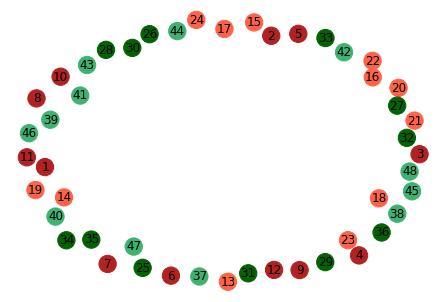

In [96]:
colour_map = create_colour_map(G, COLOURS)
nx.draw(G, node_color=colour_map, with_labels=True)
plt.show()


In [97]:
SAVE = False
if (SAVE):
    nx.write_gpickle(G, f"{PATH}/test.gpickle")    

==============================================================================================================================

The following scripts have been used to run the simulation in batches

In [ ]:
# Graph generator runs simulation and saves network as a pickle in ./saved/
if (GENERATE):
    incomplete_info = np.identity(np.sum(POPULATION))
    complete_info = np.ones((np.sum(POPULATION),np.sum(POPULATION)))
    seed = RANDOM_SEED 

    f = open(LOGFILE, "w")
    f.write(f"=====Simulation size: {np.sum(POPULATION)}, base_cl: {COST_LOW}, base_ch: {COST_HIGH}=====\n")
    f.close() 

    for c_l in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]:
        for iteration in range(0,REPEATS):
            
            budget = BUDGET
            while budget > 0:
                seed = seed + 1

                f = open(LOGFILE, "a")
                f.write(f"---Cost: {c_l}, Iteration: {iteration}---\n")
                f.close()      

                G_IC = setup_graph(seed, TYPE_DISTRIBUTION, POPULATION, DELTA, c_l, COST_HIGH, incomplete_info, BELIEF_OPTION)
                G_IC, history = run(G_IC, PERIODS, MAX_CYCLES, print_every=1000)
                if G_IC.graph['converged']:
                    nx.write_gpickle(G_IC, "%s/IC-%d-cl%s-belief%d.gpickle" %(PATH, iteration, c_l, BELIEF_OPTION))

                    G_C = setup_graph(seed, TYPE_DISTRIBUTION, POPULATION, DELTA, c_l, COST_HIGH, complete_info, BELIEF_OPTION)
                    G_C, history = run(G_C, PERIODS, MAX_CYCLES, print_every=1000)
                    if G_C.graph['converged']:
                        nx.write_gpickle(G_C, "%s/C-%d-cl%s-belief%d.gpickle" %(PATH, iteration, c_l, BELIEF_OPTION))
                        budget = 0
                    else:
                        budget = budget - 1
                else:
                    budget = budget - 1
                
        
#     for c_h in [1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0]:
    for c_h in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]:
        for iteration in range(0,REPEATS):
            
            budget = BUDGET
            while budget > 0:            
                seed = seed + 1

                f = open(LOGFILE, "a")
                f.write(f"---Cost: {c_h}, Iteration: {iteration}---\n")
                f.close()      

                G_IC = setup_graph(seed, TYPE_DISTRIBUTION, POPULATION, DELTA, COST_LOW, c_h, incomplete_info, BELIEF_OPTION)
                G_IC, history = run(G_IC, PERIODS, MAX_CYCLES, print_every=1000)
                if G_IC.graph['converged']:
                    nx.write_gpickle(G_IC, "%s/IC-%d-ch%s-belief%d.gpickle" %(PATH, iteration, c_h, BELIEF_OPTION))

                    G_C = setup_graph(seed, TYPE_DISTRIBUTION, POPULATION, DELTA, COST_LOW, c_h, complete_info, BELIEF_OPTION)
                    G_C, history = run(G_C, PERIODS, MAX_CYCLES, print_every=1000)
                    if G_C.graph['converged']:
                        nx.write_gpickle(G_C, "%s/C-%d-ch%s-belief%d.gpickle" %(PATH, iteration, c_h, BELIEF_OPTION))        
                        budget = 0
                    else:
                        budget = budget - 1
                else:
                    budget = budget - 1

In [ ]:
# Read and display a pickle
read = False
pickle_path = f"{PATH}/IC-0-cl0.8-belief5.gpickle"
if (read):
    G_pickle = nx.read_gpickle(pickle_path)
    colour_map = create_colour_map(G_pickle, POPULATION, TYPE_DISTRIBUTION, COLOURS)
    nx.draw(G_pickle, node_color=colour_map, with_labels=True)
    plt.show()


==============================================================================================================================

The code below defines a few integration test cases 

In [ ]:
import unittest

class TestFunctions(unittest.TestCase):
    
    def test_rational_exp(self):
        
        beliefs1 = create_beliefs(0, 0, 0, [[0.3, 0.7], [0.44, 0.56]])
        beliefs2 = create_beliefs(0, 1, 1, [[0.3, 0.7], [0.44, 0.56]])
        
        self.assertTrue(beliefs1 == [0.3, 0.44])
        self.assertTrue(beliefs2 == [0.7, 0.56])
        
    def test_beta_capped(self):
        beliefs1 = create_beliefs(5, 0, 0, [[0.3, 0.7], [0.44, 0.56]])
        beliefs2 = create_beliefs(5, 1, 1, [[0.3, 0.7], [0.44, 0.56]])
        
        self.assertTrue(beliefs1[0] >= beliefs1[1])
        self.assertTrue(beliefs2[0] <= beliefs2[1])

    def test_utility_correct(self):
        
        population = [4, 4]
        type_distribution = [[1,0], [0,1]]
        delta = 0.8
        dcl = 0.8 - 0.8 ** 2 - 0.01
        dch = 0.8 - 0.8 ** 2 + 0.01
        pi = [0.01 / 0.02 + 0.01, 0.01 / 0.02 + 0.01]
        inf = np.identity(np.sum(population)) 

        G_test = setup_graph(RANDOM_SEED, type_distribution, population, delta, dcl, dch, inf, -1, pi)
        
        u, c = calculate_utility_and_cost(G_test, 1, 2) 
        self.assertTrue(u + c == 0)
        
        G_test.add_edge(1,2)
        u, c = calculate_utility_and_cost(G_test, 1, 2) 

        self.assertTrue(u + c == delta - dcl)

        G_test.add_edge(1,3)
        u, c = calculate_utility_and_cost(G_test, 1, 3, new_node=3) 
        self.assertTrue(u + c == delta - pi[0] * dcl - (1-pi[0]) * dch)

        G_test.add_edge(1,5)
        u, c = calculate_utility_and_cost(G_test, 1, 5, new_node=5) 
        self.assertTrue(u + c == delta - pi[1] * dcl - (1-pi[1]) * dch)
        
    def test_net_utility_correct(self):
        population = [4, 4]
        type_distribution = [[1,0], [0,1]]
        delta = 0.8
        dcl = 0.8 - 0.8 ** 2 - 0.01
        dch = 0.8 - 0.8 ** 2 + 0.01
        pi = [0.01 / 0.02 + 0.01]
        inf = np.identity(np.sum(population)) 

        G_test = setup_graph(RANDOM_SEED, type_distribution, population, delta, dcl, dch, inf, -1, pi)
        u = calculate_net_utility(G_test, 1)
        self.assertTrue(u == 1)

        G_test.add_edge(1,2)
        u = calculate_net_utility(G_test, 1)
        self.assertTrue(u == 1 + delta - dcl)

        G_test.add_edge(1,3)
        u = calculate_net_utility(G_test, 1, 3)
        self.assertTrue(u == 1 + delta - dcl + delta - pi[0] * dcl - (1-pi[0]) * dch)
        
        u = calculate_net_utility(G_test, 1)
        self.assertTrue(u == 1 + delta - dcl + delta - dcl)
        
        G_test.add_edge(1,5)
        u = calculate_net_utility(G_test, 1)
        self.assertTrue(u == 1 + delta - dcl + delta - dcl + delta - dch)
        
        G_test.add_edge(5,6)
        u = calculate_net_utility(G_test, 1)
        self.assertTrue(round(u, 5) == round(1 + delta - dcl + delta - dcl + delta - dch + delta **2, 5))       
        
    def test_populator(self):
        population = [5, 5]
        type_distribution = [[0.5,0.5], [0.25,0.75]]
        delta = 0.8
        dcl = 0.8 - 0.8 ** 2 - 0.01
        dch = 0.8 - 0.8 ** 2 + 0.01
        pi = [0.01 / 0.02 + 0.01]
        inf = np.identity(np.sum(population)) 

        G_test = setup_graph(RANDOM_SEED, type_distribution, population, delta, dcl, dch, inf, -1, pi)
        pb = populate_graph(G, population, type_distribution, 0)
        self.assertTrue(np.all(pb[0] == [3,2]) and np.all(pb[1] == [2,3]))
    
class TestPropositions(unittest.TestCase):

    def test_everyone_meets(self):
        
        population = [4]
        type_distribution = [[1]]
        delta = 0.8
        dcl = 0.8 - 0.8 ** 2 - 0.01
        dch = 0.8 - 0.8 ** 2 + 0.01
        pi = [0.01 / 0.02 + 0.01]
        inf = np.identity(np.sum(population)) 

        G_test = setup_graph(RANDOM_SEED, type_distribution, population, delta, dcl, dch, inf, -1, pi)
        G_test, history = run(G_test, 10, MAX_CYCLES)
        self.assertTrue(np.all(G_test.graph['information'] == np.ones((G_test.number_of_nodes(), G_test.number_of_nodes()))))
    
        
    def test_meetings_begin_1(self):
        
        population = [4]
        type_distribution = [[1]]
        delta = 0.8
        dcl = 0.8 - 0.8 ** 2 - 0.01
        dch = 0.8 - 0.8 ** 2 + 0.01
        pi = [max((dch - delta) / (dch - dcl), 0.01)] # should end up being 0.01
        inf = np.identity(np.sum(population)) 
        
        # delta - delta^2 < dch < delta
        G_test = setup_graph(RANDOM_SEED, type_distribution, population, delta, dcl, dch, inf, -1, pi)
        G_test, history = run(G_test, 10, MAX_CYCLES)
        # nx.draw(history, with_labels=True)
        # plt.show()
        self.assertFalse(np.all(G_test.graph['information'] == np.identity(G_test.number_of_nodes())))
    
    def test_meetings_begin_2(self):

        # delta < dch
        # pi optimistic
        population = [4]
        type_distribution = [[1]]
        delta = 0.8
        dcl = 0.8 - 0.8 ** 2 - 0.01
        dch = delta + 0.01
        pi = [(dch - delta) / (dch - dcl) + 0.01]
        inf = np.identity(np.sum(population)) 

        
        G_test = setup_graph(RANDOM_SEED, type_distribution, population, delta, dcl, dch, inf, -1, pi)
        G_test, history = run(G_test, 10, MAX_CYCLES)
        self.assertFalse(np.all(G_test.graph['information'] == np.identity(G_test.number_of_nodes())))

    def test_meetings_do_not_begin(self):

        # delta < dch
        # pi pessimistic
        population = [4]
        type_distribution = [[1]]
        delta = 0.8
        dcl = 0.8 - 0.8 ** 2 - 0.01
        dch = delta + 0.01
        pi = [0]
        inf = np.identity(np.sum(population)) 

        # pi = [(dch - delta) / (dch - dcl) - 0.01]
        G_test = setup_graph(RANDOM_SEED, type_distribution, population, delta, dcl, dch, inf, -1, pi)
        G_test, history = run(G_test, 10, MAX_CYCLES)
        self.assertTrue(np.all(G_test.graph['information'] == np.identity(G_test.number_of_nodes())))        

            

        

        

In [ ]:
if(TEST):
    unittest.main(argv=[''], verbosity=2, exit=False)
